## IMPORT COMMON PACKAGE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import joblib

from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from yellowbrick.model_selection import learning_curve

## IMPORT DATA

In [2]:
df = pd.read_csv('CC.csv')
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x) #Change Decimal
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,SEGMENT
0,40.90,0.82,95.40,0.00,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000.00,201.80,139.51,0.00,12,0
1,3202.47,0.91,0.00,0.00,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000.00,4103.03,1072.34,0.22,12,1
2,2495.15,1.00,773.17,773.17,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500.00,622.07,627.28,0.00,12,1
3,1666.67,0.64,1499.00,1499.00,0.00,205.79,0.08,0.08,0.00,0.08,1,1,7500.00,0.00,0.00,0.00,12,1
4,817.71,1.00,16.00,16.00,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200.00,678.33,244.79,0.00,12,0


===============================================================================================================

## DATA PREPARATION

In [3]:
# Check Missing Value to ensure
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
SEGMENT                             0
dtype: int64

In [4]:
# Check Data Types to Ensure
df.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
SEGMENT                               int64
dtype: object

In [5]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,SEGMENT
0,40.90,0.82,95.40,0.00,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000.00,201.80,139.51,0.00,12,0
1,3202.47,0.91,0.00,0.00,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000.00,4103.03,1072.34,0.22,12,1
2,2495.15,1.00,773.17,773.17,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500.00,622.07,627.28,0.00,12,1
3,1666.67,0.64,1499.00,1499.00,0.00,205.79,0.08,0.08,0.00,0.08,1,1,7500.00,0.00,0.00,0.00,12,1
4,817.71,1.00,16.00,16.00,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200.00,678.33,244.79,0.00,12,0


===============================================================================================================

## SEGMENT DISTRIBUTION CHECK

In [6]:
df['SEGMENT'].value_counts()

0    5620
1    2654
2     675
Name: SEGMENT, dtype: int64

In [7]:
pd.crosstab(index=df['SEGMENT'], columns='count', normalize=True)*100
## Because the data is multiclass, we will not considered it as imbalanced class

col_0,count
SEGMENT,
0,62.80
1,29.66
2,7.54


===============================================================================================================

## MACHINE LEARNING FOCUS

Since our dataset have 3 SEGMENT/**Multiclass** where:
- **SEGMENT 0**: LOW CUSTOMERS      
- **SEGMENT 1**: MEDIUM CUSTOMERS       
- **SEGMENT 2**: HIGH CUSTOMERS   

We will **focus** to obtain Machine Learning Model with the best **Accuracy Score**

===============================================================================================================

## FEATURES SELECTION
- For this model we will use all features, because from EDA results, the customer segmentation is affected by all features from dataset

===============================================================================================================

## SPLITING DATA

In [8]:
X = df.drop(columns='SEGMENT')
y = df['SEGMENT']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 42)

===============================================================================================================

## MACHINE LEARNING MODELING

========================================================================================

### 1. RANDOM FOREST

#### 1A. RANDOM FOREST - BASE MODEL

In [10]:
RF_Base = RandomForestClassifier()

In [11]:
RF_Base.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
y_pred_tr_RFBase = RF_Base.predict(X_train)

In [13]:
print(classification_report(y_train, y_pred_tr_RFBase))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4496
           1       1.00      1.00      1.00      2123
           2       1.00      1.00      1.00       540

    accuracy                           1.00      7159
   macro avg       1.00      1.00      1.00      7159
weighted avg       1.00      1.00      1.00      7159



In [14]:
y_pred_ts_RFBase = RF_Base.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred_ts_RFBase))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1124
           1       0.98      0.98      0.98       531
           2       0.98      0.96      0.97       135

    accuracy                           0.99      1790
   macro avg       0.98      0.98      0.98      1790
weighted avg       0.99      0.99      0.99      1790



In [16]:
cm_RF_Base = confusion_matrix(y_test, y_pred_ts_RFBase , labels=[0, 1, 2])

In [17]:
df_RF_Base = pd.DataFrame(cm_RF_Base, index=['Akt 0', 'Akt 1', 'Akt 2'], columns =  ['Pred 0', 'Pred 1', 'Pred 2'])
df_RF_Base

,Pred 0,Pred 1,Pred 2
Akt 0,1117,7,0
Akt 1,6,522,3
Akt 2,0,6,129


In [18]:
RFTB = accuracy_score(y_test, y_pred_ts_RFBase)

In [19]:
RFTrainB = accuracy_score(y_train, y_pred_tr_RFBase)

- Random Forest result accuracy is already good, in other hand, this model is categorized as strong learner model which causing the model might be only memorizing the data, and not learning the pattern. So we want to decrease accuracy score to get a good learner and get more suitable confusion matrix through HYPER PARAMETER TUNING

#### 1B. RANDOM FOREST - HYPER PARAMETER TUNING (FINE TUNING)

In [20]:
param_RF2 = {
    "n_estimators" : [700, 750, 800],
    "max_depth" : [3,4],
    "min_samples_leaf" :[20, 25,30],
    "class_weight" : [{0:x, 1: 1 - x} for x in [.15, .20]]
}

In [21]:
RF_rand2 = RandomForestClassifier()

In [22]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [23]:
RF_GS1 = GridSearchCV(RF_rand2, param_RF2, cv=skf, n_jobs=-1, verbose=1, scoring='accuracy')

In [24]:
RF_GS1.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.15, 1: 0.85}, {0: 0.2, 1: 0.8}],
                         'max_depth': [3, 4], 'min_samples_leaf': [20, 25, 30],
                         'n_estimators': [700, 750, 800]},
             scoring='accuracy', verbose=1)

In [25]:
RF_GS1.best_params_

{'class_weight': {0: 0.2, 1: 0.8},
 'max_depth': 4,
 'min_samples_leaf': 25,
 'n_estimators': 700}

In [26]:
Model_GS1_Tuned = RF_GS1.best_estimator_

In [27]:
y_pred_tr_RF2_Tuned = Model_GS1_Tuned.predict(X_train)

In [28]:
print(classification_report(y_train, y_pred_tr_RF2_Tuned))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4496
           1       0.83      1.00      0.91      2123
           2       1.00      0.61      0.76       540

    accuracy                           0.94      7159
   macro avg       0.94      0.85      0.88      7159
weighted avg       0.95      0.94      0.94      7159



In [29]:
y_pred_ts_RF2_Tuned = Model_GS1_Tuned.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred_ts_RF2_Tuned))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1124
           1       0.82      0.99      0.90       531
           2       1.00      0.62      0.77       135

    accuracy                           0.93      1790
   macro avg       0.94      0.85      0.88      1790
weighted avg       0.94      0.93      0.93      1790



In [31]:
cm_RF2_Tuned = confusion_matrix(y_test, y_pred_ts_RF2_Tuned, labels=[0, 1, 2])

In [32]:
df_RF2_Tuned = pd.DataFrame(cm_RF2_Tuned, index=['Akt 0', 'Akt 1', 'Akt 2'], columns = ['Pred 0', 'Pred 1', 'Pred 2'])
df_RF2_Tuned

,Pred 0,Pred 1,Pred 2
Akt 0,1059,65,0
Akt 1,4,527,0
Akt 2,0,51,84


In [33]:
RFT = accuracy_score(y_test, y_pred_ts_RF2_Tuned)

In [34]:
RFTrainTuned = accuracy_score(y_train, y_pred_tr_RF2_Tuned)

===============================================================================================================

### 2.LOGISTIC REGRESSION

#### 2A. LOGISTIC REGRESSION - BASE MODEL

In [35]:
LR_Base = LogisticRegression()

In [36]:
LR_Base.fit(X_train, y_train)

LogisticRegression()

In [37]:
y_pred_tr_LRBase = LR_Base.predict(X_train)

In [38]:
print(classification_report(y_train, y_pred_tr_LRBase))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4496
           1       0.83      0.89      0.86      2123
           2       0.76      0.54      0.63       540

    accuracy                           0.91      7159
   macro avg       0.85      0.80      0.82      7159
weighted avg       0.91      0.91      0.91      7159



In [39]:
y_pred_ts_LRBase = LR_Base.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_ts_LRBase))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1124
           1       0.85      0.89      0.87       531
           2       0.78      0.62      0.69       135

    accuracy                           0.92      1790
   macro avg       0.87      0.83      0.84      1790
weighted avg       0.92      0.92      0.92      1790



In [41]:
cm_LR_Base = confusion_matrix(y_test, y_pred_ts_LRBase , labels=[0, 1, 2])

In [42]:
df_LR_Base = pd.DataFrame(cm_LR_Base, index=['Akt 0', 'Akt 1', 'Akt 2'], columns =  ['Pred 0', 'Pred 1', 'Pred 2'])
df_LR_Base

,Pred 0,Pred 1,Pred 2
Akt 0,1090,34,0
Akt 1,34,473,24
Akt 2,0,51,84


In [43]:
LogRegT = accuracy_score(y_test, y_pred_ts_LRBase)

In [44]:
LogRegTr = accuracy_score(y_train, y_pred_tr_LRBase)

#### 2B. LOGISTIC REGRESSION - HYPERPARAMETER TUNING

In [45]:
param_LR = {
    'penalty' : ['none', 'l1', 'l2'],
    'C' : np.logspace(-4 , 4, 14),
    'class_weight' : [{0 : x, 1 : 1 - x} for x in [.05,.1,.15, .2,]]
}

In [46]:
LR_HP = LogisticRegression()

In [47]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [48]:
LR_GS = GridSearchCV(LR_HP, param_LR, cv=skf, n_jobs=-1, verbose=1, scoring='accuracy')

In [49]:
LR_GS.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   17.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 4.12462638e-04, 1.70125428e-03, 7.01703829e-03,
       2.89426612e-02, 1.19377664e-01, 4.92388263e-01, 2.03091762e+00,
       8.37677640e+00, 3.45510729e+01, 1.42510267e+02, 5.87801607e+02,
       2.42446202e+03, 1.00000000e+04]),
                         'class_weight': [{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.2, 1: 0.8}],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='accuracy', verbose=1)

In [50]:
LR_GS.best_params_

{'C': 0.00701703828670383, 'class_weight': {0: 0.2, 1: 0.8}, 'penalty': 'l2'}

In [51]:
LR_GS_Tuned = LR_GS.best_estimator_

In [52]:
y_pred_LR_tr_Tuned = LR_GS_Tuned.predict(X_train)

In [53]:
print(classification_report(y_train, y_pred_LR_tr_Tuned))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87      4496
           1       0.62      0.83      0.71      2123
           2       0.49      0.74      0.59       540

    accuracy                           0.79      7159
   macro avg       0.70      0.78      0.72      7159
weighted avg       0.85      0.79      0.80      7159



In [54]:
y_pred_LR_ts_Tuned = LR_GS_Tuned.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred_LR_ts_Tuned))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1124
           1       0.63      0.81      0.71       531
           2       0.49      0.79      0.60       135

    accuracy                           0.79      1790
   macro avg       0.70      0.79      0.73      1790
weighted avg       0.85      0.79      0.81      1790



In [56]:
cm_LR_Tuned = confusion_matrix(y_test, y_pred_LR_ts_Tuned, labels=[0, 1, 2])

In [57]:
df_LR_Tuned = pd.DataFrame(cm_LR_Tuned, index=['Akt 0', 'Akt 1', 'Akt 2'], columns =  ['Pred 0', 'Pred 1', 'Pred 2'])
df_LR_Tuned

,Pred 0,Pred 1,Pred 2
Akt 0,886,226,12
Akt 1,4,428,99
Akt 2,1,28,106


In [58]:
LogRegTHP = accuracy_score(y_test, y_pred_LR_ts_Tuned)

In [59]:
LogRegTrainHP = accuracy_score(y_train, y_pred_LR_tr_Tuned)

===============================================================================================================

### 3.KNN CLASSIFIER

#### 3A. KNN CLASSIFIER - BASE MODEL

In [60]:
KNNB = KNeighborsClassifier()

In [61]:
KNNB.fit(X_train, y_train)

KNeighborsClassifier()

In [62]:
y_pred_tr_KNNB = KNNB.predict(X_train)

In [63]:
print(classification_report(y_train, y_pred_tr_KNNB))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4496
           1       0.98      0.98      0.98      2123
           2       0.98      0.94      0.96       540

    accuracy                           0.99      7159
   macro avg       0.98      0.97      0.98      7159
weighted avg       0.99      0.99      0.99      7159



In [64]:
y_pred_ts_KNNB = KNNB.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred_ts_KNNB))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1124
           1       0.97      0.97      0.97       531
           2       0.98      0.93      0.95       135

    accuracy                           0.98      1790
   macro avg       0.98      0.96      0.97      1790
weighted avg       0.98      0.98      0.98      1790



In [66]:
cm_KNNB = confusion_matrix(y_test, y_pred_ts_KNNB, labels=[0, 1, 2])

In [67]:
df_cmKNNB = pd.DataFrame(cm_KNNB, index=['Akt 0', 'Akt 1', 'Akt 2'], columns =  ['Pred 0', 'Pred 1', 'Pred 2'])
df_cmKNNB

,Pred 0,Pred 1,Pred 2
Akt 0,1117,7,0
Akt 1,13,515,3
Akt 2,0,10,125


In [68]:
KNNT = accuracy_score(y_test, y_pred_ts_KNNB)

In [69]:
KNNTr = accuracy_score(y_train, y_pred_tr_KNNB)

===============================================================================================================

# SUMMARY & RECOMMENDATION

### - MACHINE LEARNING SUMMARY

In [70]:
list_accuracy_score = [RFTB, RFT, LogRegT, LogRegTHP, KNNT]

In [71]:
tab_acc_sc = pd.DataFrame(data = list_accuracy_score, columns=['Accuracy Score Test'], index= ['Random Forest Base Model', 'Random Forest Tuned', 'Log Reg Base Model', 'Log Reg Tuned', 'KNN Base Model'])

In [72]:
list_accuracy_score_train = [RFTrainB, RFTrainTuned, LogRegTr, LogRegTrainHP, KNNTr]

In [73]:
tab_acc_sc['Accuracy Score Train'] = list_accuracy_score_train
tab_acc_sc

,Accuracy Score Test,Accuracy Score Train
Random Forest Base Model,0.99,1.00
Random Forest Tuned,0.93,0.94
Log Reg Base Model,0.92,0.91
Log Reg Tuned,0.79,0.79
KNN Base Model,0.98,0.99


In [74]:
### Last Model Evaluation Matrix
print(classification_report(y_test, y_pred_ts_RF2_Tuned))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1124
           1       0.82      0.99      0.90       531
           2       1.00      0.62      0.77       135

    accuracy                           0.93      1790
   macro avg       0.94      0.85      0.88      1790
weighted avg       0.94      0.93      0.93      1790



In [75]:
df_RF2_Tuned = pd.DataFrame(cm_RF2_Tuned, index=['Akt 0', 'Akt 1', 'Akt 2'], columns = ['Pred 0', 'Pred 1', 'Pred 2'])
df_RF2_Tuned

,Pred 0,Pred 1,Pred 2
Akt 0,1059,65,0
Akt 1,4,527,0
Akt 2,0,51,84


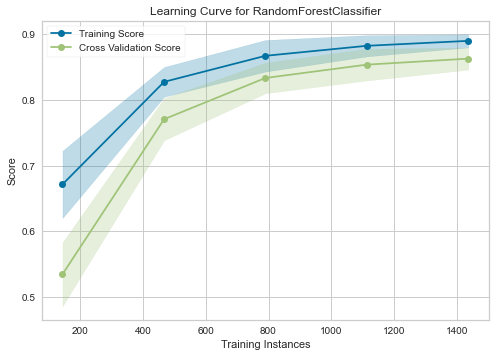

LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>,
              cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
              estimator=RandomForestClassifier(class_weight={0: 0.2, 1: 0.8},
                                               max_depth=4, min_samples_leaf=25,
                                               n_estimators=700),
              scoring='accuracy')


In [76]:
X, y = load_digits(return_X_y=True)

rfc = Model_GS1_Tuned
cv_1 = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
print(learning_curve(rfc, X, y, cv=cv_1, scoring='accuracy'))

- The learning curve graphic shows that the model has relatively stable result 

- From the initial machine learning modelling, there are **no overfit result** on all over model algorithm
- We **suggest** to use **Random Forest Tuned 2**, because after analysis it has the best accuracy score 93% (not so high) with the most suitable confusion matrix 
- How this model will help bank company?
    - This model will allow bank marketing team to take actions on identified as "customer segment", furthermore the development of these model should contribute to bank revenue management.
    - These prediction models enable marketing teams to mitigate profit loss derived from customer churn caused by unsuitable marketing program

### - MACHINE LEARNING RECOMMENDATION

- This Machine Learning could be used for **customer segmentation based on their credit card usage behaviour**.
- The result from this project could be used by **marketing team** to offer suitable product for new customers based on their segmentation which is predict through Machine Learning Model

===============================================================================================================

## BUSINESS PROFIT ROUGH CALCULATION

From our research (https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/), current **credit card churn is about 25%**.
With the help of our Clustering and Multiclass Machine Learning Modeling, we simulate that credit card churn **will drop into 7%**.

Assuming number of customers and lost per customers as down below:

In [77]:
data1 = [1000000, 80]

In [78]:
data_tab = pd.DataFrame(data = data1, columns = ['VALUE'], index= ['Number of Credit Card Customer Simulation', 'Cost per Customer Lost Simulation (In Dollar)'])
data_tab

,VALUE
Number of Credit Card Customer Simulation,1000000
Cost per Customer Lost Simulation (In Dollar),80


Attached below is **rough calculation** Lost Customer Cost Without Machine Learning vs Lost Customer Cost with Machine Learning

In [79]:
data2 = [['25%', 250000, 20000000], ['7%',70000, 5600000]]

In [80]:
data_tab2 = pd.DataFrame(data = data2, columns = ['Percentage Churn', 'Number of People Churn', 'Lost Customer Cost Calculation'], index= ['Current Credit Churn Situation (Without Machine Learning)', 'Credit Churn Simulation Using Machine Learning (Accuracy 93%)'])
data_tab2

,Percentage Churn,Number of People Churn,Lost Customer Cost Calculation
Current Credit Churn Situation (Without Machine Learning),25%,250000,20000000
Credit Churn Simulation Using Machine Learning (Accuracy 93%),7%,70000,5600000


Using our Multiclass Machine Learning Modelling, our company **could save money** around **14,400,000 dollars!!**

In [81]:
data3 = 14400000

In [82]:
data_tab3 = pd.DataFrame(data = data3, columns = ['Value'], index= ['Cost Saving Using Machine Learning'])
data_tab3

,Value
Cost Saving Using Machine Learning,14400000


## FURTHER RESEARCH (NEXT ACTION)

- For further research information, customer behaviour (Payment history, Length of credit history, New credit, The variety of credit products you have, including credit cards, installment loans, finance company accounts, mortgage loans and so on) could be included into the dataset in hope to improve the models and measure the importance of these features

===============================================================================================================

## EXPORT SELECTED MODEL

In [83]:
joblib.dump(Model_GS1_Tuned, 'ModelCreditCard')

['ModelCreditCard']